In [2]:
##  Imports & Setup

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV

from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb



##  Data Loading

In [3]:
TARGET = "exam_score"
ID_COL = "id"
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=67)

# Paths
DATA_DIR = Path('../data/processed')
SUBMISSION_DIR = Path('../submissions')
SUBMISSION_DIR.mkdir(parents=True, exist_ok=True)

X_train = np.load(DATA_DIR / 'X_train.npy')
y_train = np.load(DATA_DIR / 'y_train.npy')
X_test = np.load(DATA_DIR / 'X_test.npy')
test_ids = np.load(DATA_DIR / 'test_ids.npy')

# Convert to DataFrame to use column names
x_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
x_test = pd.DataFrame(X_test)
test_ids = pd.DataFrame(test_ids)

In [4]:

oof_cb = np.zeros(len(x_train))
test_cb = np.zeros(len(x_test))

for fold, (tr, va) in enumerate(kf.split(x_train)):
    print(f"CatBoost Fold {fold+1}")

    model = CatBoostRegressor(
        iterations=4000,
        learning_rate=0.03,
        depth=8,
        l2_leaf_reg=6,
        loss_function="RMSE",
        eval_metric="RMSE",
        random_seed=67 + fold,
        verbose=300,
        task_type="CPU"
    )

    model.fit(
        x_train.iloc[tr], y_train.iloc[tr],
        eval_set=(x_train.iloc[va], y_train.iloc[va]),
        use_best_model=True
    )

    oof_cb[va] = model.predict(x_train.iloc[va])
    test_cb += model.predict(x_test) / FOLDS

CatBoost Fold 1
0:	learn: 18.5269982	test: 18.4670138	best: 18.4670138 (0)	total: 107ms	remaining: 7m 6s
300:	learn: 8.8237905	test: 8.8553272	best: 8.8553272 (300)	total: 7.37s	remaining: 1m 30s
600:	learn: 8.7735363	test: 8.8229836	best: 8.8229836 (600)	total: 14.3s	remaining: 1m 20s
900:	learn: 8.7350130	test: 8.8028608	best: 8.8028608 (900)	total: 21.2s	remaining: 1m 12s
1200:	learn: 8.7024458	test: 8.7898217	best: 8.7898217 (1200)	total: 28s	remaining: 1m 5s
1500:	learn: 8.6735311	test: 8.7817619	best: 8.7817619 (1500)	total: 35s	remaining: 58.3s
1800:	learn: 8.6465334	test: 8.7748570	best: 8.7748534 (1799)	total: 41.8s	remaining: 51.1s
2100:	learn: 8.6210634	test: 8.7697696	best: 8.7697696 (2100)	total: 48.6s	remaining: 43.9s
2400:	learn: 8.5960450	test: 8.7656561	best: 8.7656507 (2399)	total: 55.5s	remaining: 37s
2700:	learn: 8.5730510	test: 8.7628394	best: 8.7628295 (2696)	total: 1m 2s	remaining: 30s
3000:	learn: 8.5498356	test: 8.7604509	best: 8.7604312 (2996)	total: 1m 9s	rem

In [ ]:
oof_lgb = np.zeros(len(x_train))
test_lgb = np.zeros(len(x_test))

for fold, (tr, va) in enumerate(kf.split(x_train)):
    print(f"LightGBM Fold {fold+1}")

    model = lgb.LGBMRegressor(
        n_estimators=5000,
        learning_rate=0.03,
        max_depth=-1,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="regression",
        random_state=67 + fold
    )

    model.fit(
        x_train.iloc[tr], y_train.iloc[tr],
        eval_set=[(x_train.iloc[va], y_train.iloc[va])],
        eval_metric="rmse",
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(300)]
    )

    oof_lgb[va] = model.predict(x_train.iloc[va])
    test_lgb += model.predict(x_test) / FOLDS

🌿 LightGBM Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3886
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 47
[LightGBM] [Info] Start training from score 62.510761
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 8.81073	valid_0's l2: 77.6289
[600]	valid_0's rmse: 8.78742	valid_0's l2: 77.2187
[900]	valid_0's rmse: 8.77548	valid_0's l2: 77.0091
[1200]	valid_0's rmse: 8.76739	valid_0's l2: 76.8671
[1500]	valid_0's rmse: 8.76049	valid_0's l2: 76.7462
[1800]	valid_0's rmse: 8.75751	valid_0's l2: 76.6939
[2100]	valid_0's rmse: 8.75586	valid_0's l2: 76.665
[2400]	valid_0's rmse: 8.7545	valid_0's l2: 76.6412
[2700]	valid_0's rmse: 8.75396	valid_0's l2: 76.6319
[3000]	valid_0's rmse: 8.75349	valid_0's

In [6]:
X_enc = pd.get_dummies(x_train, drop_first=True)
test_enc = pd.get_dummies(x_test, drop_first=True)
test_enc = test_enc.reindex(columns=X_enc.columns, fill_value=0)

oof_xgb = np.zeros(len(x_train))
test_xgb = np.zeros(len(x_test))

for fold, (tr, va) in enumerate(kf.split(X_enc)):
    print(f" XGBoost Fold {fold+1}")

    model = xgb.XGBRegressor(
        n_estimators=4000,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        tree_method="hist",
        eval_metric="rmse",
        random_state=42 + fold
    )

    model.fit(
        X_enc.iloc[tr], y_train.iloc[tr],
        eval_set=[(X_enc.iloc[va], y_train.iloc[va])],
        verbose=300
    )

    oof_xgb[va] = model.predict(X_enc.iloc[va])
    test_xgb += model.predict(test_enc) / FOLDS


 XGBoost Fold 1
[0]	validation_0-rmse:18.44313
[300]	validation_0-rmse:8.79861
[600]	validation_0-rmse:8.77284
[900]	validation_0-rmse:8.76247
[1200]	validation_0-rmse:8.75878
[1500]	validation_0-rmse:8.75841
[1800]	validation_0-rmse:8.76006
[2100]	validation_0-rmse:8.76291
[2400]	validation_0-rmse:8.76867
[2700]	validation_0-rmse:8.77351
[3000]	validation_0-rmse:8.77745
[3300]	validation_0-rmse:8.78273
[3600]	validation_0-rmse:8.78921
[3900]	validation_0-rmse:8.79466
[3999]	validation_0-rmse:8.79718
 XGBoost Fold 2
[0]	validation_0-rmse:18.48971
[300]	validation_0-rmse:8.79050
[600]	validation_0-rmse:8.76500
[900]	validation_0-rmse:8.75683
[1200]	validation_0-rmse:8.75491
[1500]	validation_0-rmse:8.75565
[1800]	validation_0-rmse:8.75871
[2100]	validation_0-rmse:8.76270
[2400]	validation_0-rmse:8.76713
[2700]	validation_0-rmse:8.77214
[3000]	validation_0-rmse:8.77869
[3300]	validation_0-rmse:8.78445
[3600]	validation_0-rmse:8.79051
[3900]	validation_0-rmse:8.79712
[3999]	validation_0-r

In [ ]:
X_stack = np.column_stack([oof_cb, oof_lgb, oof_xgb])
X_test_stack = np.column_stack([test_cb, test_lgb, test_xgb])

ridge = RidgeCV(alphas=np.logspace(-2, 4, 100), cv=5)
ridge.fit(X_stack, y_train)

oof_stack = ridge.predict(X_stack)
test_stack = ridge.predict(X_test_stack)

rmse = mean_squared_error(y_train.squeeze(), oof_stack)
print(f"🔥 FINAL STACK RMSE: {rmse:.6f}")


## Feature Importances for All Models
This section visualizes feature importances for LightGBM, CatBoost, XGBoost, and RidgeCV (if available).

In [ ]:
# LightGBM Feature Importances
lgb_importances = model.feature_importances_ if 'model' in locals() else None
if lgb_importances is not None:
    plt.figure(figsize=(10,6))
    sns.barplot(x=lgb_importances, y=x_train.columns)
    plt.title('LightGBM Feature Importances')
    plt.show()
else:
    print('LightGBM model not found. Run the LightGBM cell first.')

LightGBM model not found. Run the LightGBM cell first.


In [ ]:
# CatBoost Feature Importances
try:
    catboost_model = model  # If last model is CatBoost
    importances = catboost_model.get_feature_importance()
    plt.figure(figsize=(10,6))
    sns.barplot(x=importances, y=x_train.columns)
    plt.title('CatBoost Feature Importances')
    plt.show()
except Exception as e:
    print('CatBoost model not found or not fitted. Run the CatBoost cell first.')

In [ ]:
# XGBoost Feature Importances
try:
    xgb_model = model  # If last model is XGBoost
    importances = xgb_model.feature_importances_
    plt.figure(figsize=(10,6))
    sns.barplot(x=importances, y=X_enc.columns)
    plt.title('XGBoost Feature Importances')
    plt.show()
except Exception as e:
    print('XGBoost model not found or not fitted. Run the XGBoost cell first.')

In [ ]:
# RidgeCV Feature Importances (Coefficients)
try:
    ridge_coefs = ridge.coef_
    plt.figure(figsize=(10,6))
    sns.barplot(x=ridge_coefs, y=['CatBoost', 'LightGBM', 'XGBoost'])
    plt.title('RidgeCV Stacking Coefficients')
    plt.show()
except Exception as e:
    print('RidgeCV model not found or not fitted. Run the stacking cell first.')

In [ ]:
rmse = mean_squared_error(oof_stack, y_train)
print(f"FINAL STACK RMSE: {rmse:.6f}")

NameError: name 'mean_squared_error' is not defined

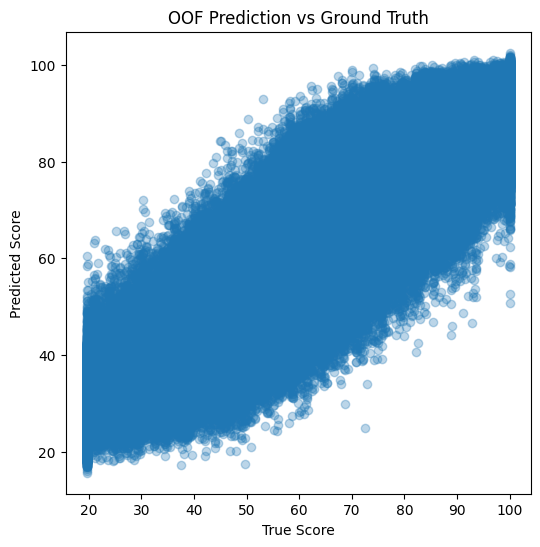

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_train, oof_stack, alpha=0.3)
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("OOF Prediction vs Ground Truth")
plt.show()


In [ ]:
submission = pd.DataFrame({
    "ID": test_ids.squeeze(),
    TARGET: test_stack
})

In [ ]:
# Save submission CSV
submission_path = SUBMISSION_DIR / 'stack_submission.csv'
submission.to_csv(submission_path, index=False)

print(f"✅ Submission saved to: {submission_path}")
print(f"\nFile size: {submission_path.stat().st_size / 1024:.2f} KB")

# Verify the saved file
print("\nFirst few lines of saved submission:")
print(pd.read_csv(submission_path).head())

✅ Submission saved to: ../submissions/stack_submission.csv

File size: 6603.91 KB

First few lines of saved submission:
       ID  exam_score
0  630000   70.916187
1  630001   70.126674
2  630002   87.650655
3  630003   55.413019
4  630004   47.869238
